In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
% matplotlib inline
plt.style.reload_library()
plt.style.use('ggplot')
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
import numpy as np
import math

Single Module Experiment
---------------------------

In [35]:
from models.BGTC import Thalamus

# model parameters
n_populations = 2
n_synapses = 3
step_size = 1e-3
max_synaptic_delay = None
resting_potentials = [0., 0.]
connectivity_scaling = 20.
synapse_params = [dict(), {'efficacy': -0.001, 'tau_decay': 1./40, 'tau_rise': 1./130}, dict()]

# instantiate thalamus
thalamus = Thalamus(step_size=step_size, max_synaptic_delay=max_synaptic_delay, resting_potentials=resting_potentials,
                    connectivity_scaling=connectivity_scaling, synapse_params=synapse_params)

# simulation parameters
simulation_time = 10.
cutoff_time = 5.
input_start = int(7.5 / step_size)
simulation_steps = int(simulation_time / step_size)

# input parameters
sensory_inp_mean = 150.
sensory_inp_var = 4.
cortical_inp = 25.
modulatory_inp = 15.
lateral_inhibition = 20.

# input definition
synaptic_input = np.zeros((simulation_steps, n_populations, n_synapses))
synaptic_input[:, 0, 0] += sensory_inp_var * np.random.randn(simulation_steps) + sensory_inp_mean
synaptic_input[:, 0, 0] += cortical_inp
synaptic_input[:, 1, 0] += 2 * cortical_inp
synaptic_input[input_start:, 0, 0] += modulatory_inp
synaptic_input[input_start:, 1, 1] += modulatory_inp * 6.
synaptic_input[:, 1, 1] += lateral_inhibition

# simulation
thalamus.run(synaptic_input, simulation_time)

/home/raid2/rgast/anaconda3/envs/mne_gpc/lib/python3.6/site-packages/PyRates-0.2-py3.6.egg/core/utility/bio_features.py:206: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp((firing_rate - threshold) / steepness))


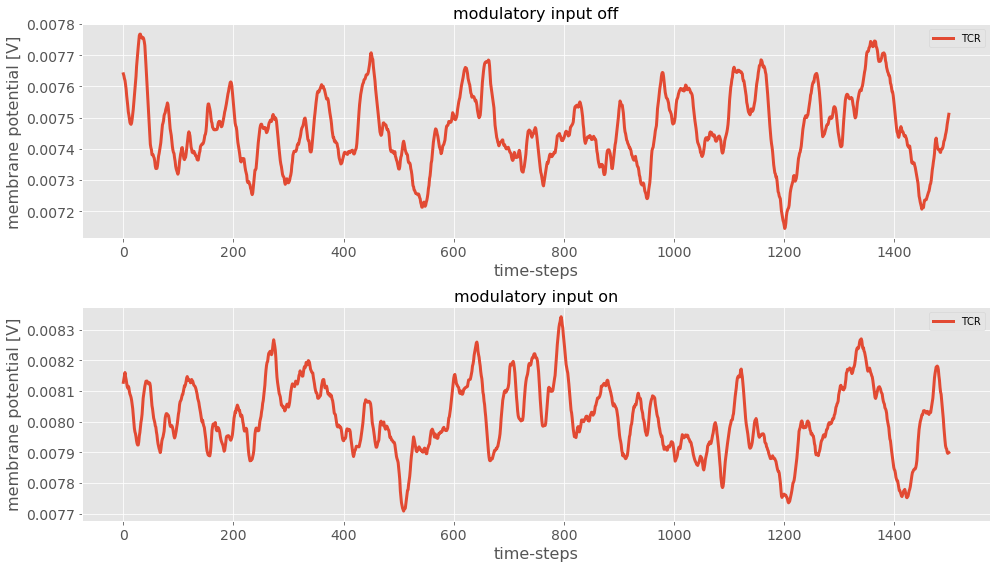

In [36]:
fig, axes = plt.subplots(2, 1, figsize=(14,8))

plot_range_1 = [cutoff_time + 0.5, cutoff_time + 2.0]
plot_range_2 = [plot_range_1[1] + 1.5, plot_range_1[1]+ 3.]

axes[0] = thalamus.plot_population_states([0], create_plot=False, axes=axes[0], time_window=[plot_range_1[0], plot_range_1[1]])
axes[0].set_title('modulatory input off')
axes[1] = thalamus.plot_population_states([0], create_plot=False, axes=axes[1], time_window=[plot_range_2[0], plot_range_2[1]])
axes[1].set_title('modulatory input on')

plt.tight_layout()

Two Coupled Modules
-----------------------

In [454]:
from core.circuit import CircuitFromCircuit
from models.BGTC import Thalamus

# create coupled thalamus model
###############################

# thalamus parameters
n_populations = 2
n_synapses = 3
step_size = 1e-3
max_synaptic_delay = None
resting_potentials = [0., 0.]
connectivity_scaling = 20.
synapse_params = [dict(), {'efficacy': -0.001, 'tau_decay': 1./40}, dict()]

# thalamus objects
thalamus_1 = Thalamus(step_size=step_size, max_synaptic_delay=max_synaptic_delay, resting_potentials=resting_potentials,
                      connectivity_scaling=connectivity_scaling, synapse_params=synapse_params)
thalamus_2 = Thalamus(step_size=step_size, max_synaptic_delay=max_synaptic_delay, resting_potentials=resting_potentials,
                      connectivity_scaling=connectivity_scaling, synapse_params=synapse_params)

# connectivity
connectivity = np.zeros((2, 2, n_synapses))
lateral_inhibition = 0.4
connectivity[0, 1, 1] = lateral_inhibition * connectivity_scaling
connectivity[1, 0, 1] = lateral_inhibition * connectivity_scaling

# input and output populations
input_pops = np.ones((2, 2, 1), dtype=int).tolist()
output_pops = np.ones((2, 2), dtype=int)

# create coupled model
circuit = CircuitFromCircuit([thalamus_1, thalamus_2], connectivity=connectivity, input_populations=input_pops,
                             output_populations=output_pops, circuit_labels=['TH1', 'TH2'])

# perform simulation
####################

# simulation parameters
simulation_time = 17.
cutoff_time = 1.
input_start = int(7. / step_size)
input_end = int(11. / step_size)
simulation_steps = int(simulation_time / step_size)

synaptic_input = np.zeros((simulation_steps, 2 * n_populations, n_synapses))

# input parameters
sensory_inp_mean = 150.
sensory_inp_var = 2.
cortical_inp = 25.
modulatory_inp = 15.

# input to thalamus 1
synaptic_input[:, 0, 0] += sensory_inp_var * np.random.randn(simulation_steps) + sensory_inp_mean
synaptic_input[:, 0, 0] += cortical_inp
synaptic_input[:, 1, 0] += 2 * cortical_inp
synaptic_input[input_start:input_end, 0, 0] += modulatory_inp
synaptic_input[input_start:input_end, 1, 1] += modulatory_inp * 6.

# input to thalamus 2
synaptic_input[:, 2, 0] += sensory_inp_var * np.random.randn(simulation_steps) + sensory_inp_mean
synaptic_input[:, 2, 0] += cortical_inp
synaptic_input[:, 3, 0] += 2 * cortical_inp

# run simulation
circuit.run(synaptic_input, simulation_time)

/home/raid2/rgast/anaconda3/envs/mne_gpc/lib/python3.6/site-packages/PyRates-0.2-py3.6.egg/core/utility/bio_features.py:206: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp((firing_rate - threshold) / steepness))


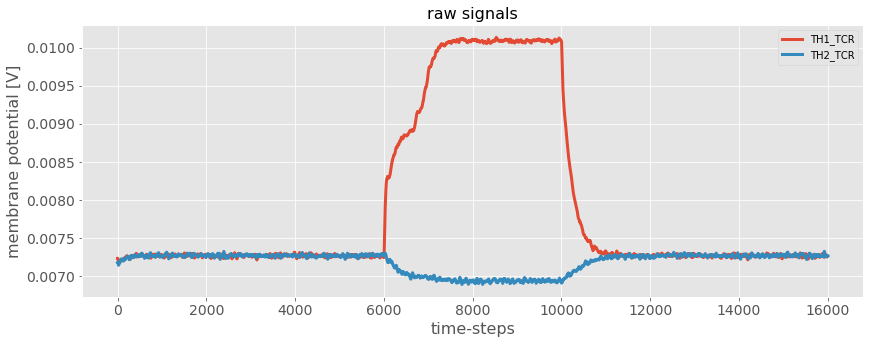

In [455]:
fig, axes = plt.subplots(figsize=(14,5))
axes = circuit.plot_population_states([0, 2], create_plot=False, axes=axes, time_window=[cutoff_time, simulation_time])
axes.set_title('raw signals')

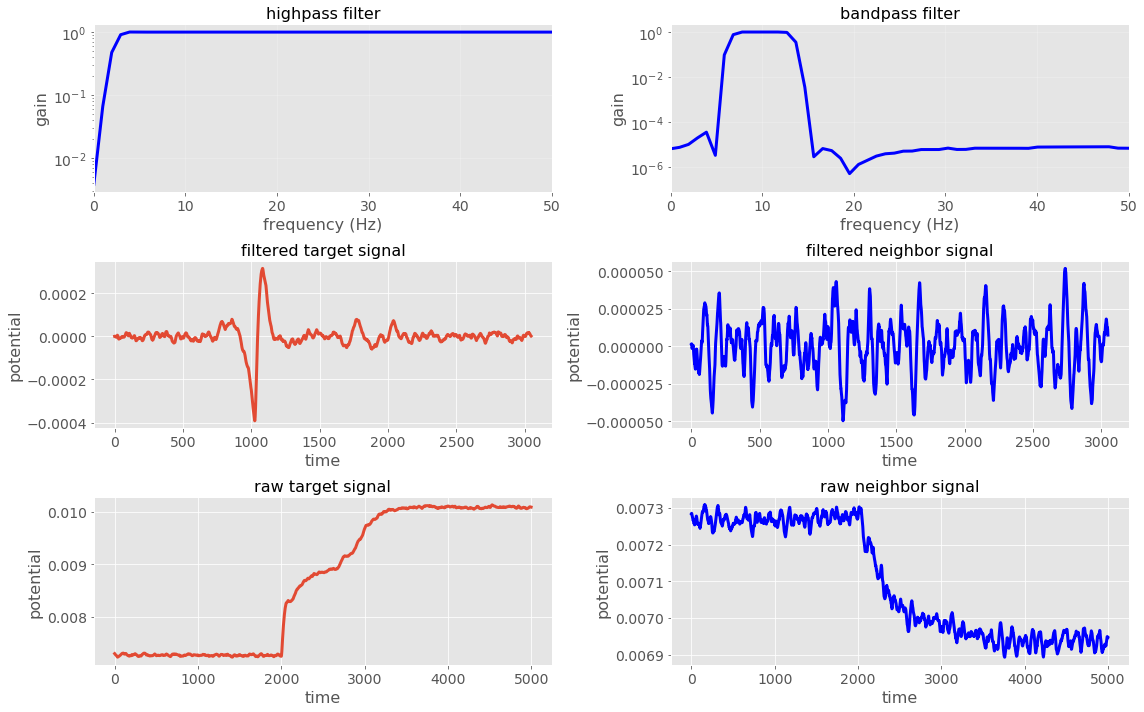

In [476]:
from scipy import signal

#################
# preprocessing #
#################

# filtering
###########

# get signal
signals = circuit.get_population_states(0, [0, 2], time_window=[cutoff_time, simulation_time])

# highpass filter signal
filter_order = 1024
cutoff = 2.
hpass = signal.firwin(filter_order + 1, cutoff, pass_zero=False, fs=1/step_size)
hpass_filtered_signals = np.array([signal.convolve(hpass, signals[:, i]) for i in range(signals.shape[1])])

# bandpass signal around 8-12 H
stop = [5., 15.]
band = [8., 12.]
gains = [0, 1, 0]
bpass = signal.remez(2*filter_order, [0., stop[0], band[0], band[1], stop[1], 500.], gains, fs=1/step_size)
bpass_filtered_signals = np.array([signal.convolve(hpass_filtered_signals[i, :], hpass) for i in range(hpass_filtered_signals.shape[0])])

# remove pre- and post phase
remove_size = int(2. / step_size)
bpass_filtered_signals = bpass_filtered_signals[:, remove_size:-remove_size]

# remove spikes: CAREFUL -> HACK
#spike_time_1 = [4800, 5200]
#spike_time_2 = [8800, 9200]
#bpass_filtered_signals[0, spike_time_1[0]:spike_time_1[1]] = 0.
#bpass_filtered_signals[0, spike_time_2[0]:spike_time_2[1]] = 0.

# filter plotting
#################

fig, axes = plt.subplots(3, 2, figsize=(16, 10))

hp_freq, hp_response = signal.freqz(hpass)
bp_freq, bp_response = signal.freqz(bpass)

# highpass filter
axes[0, 0].semilogy(0.5*(1/step_size)*hp_freq/np.pi, np.abs(hp_response), 'b-')
axes[0, 0].grid(alpha=0.25)
axes[0, 0].set_xlim(0, 50)
axes[0, 0].set_xlabel('frequency (Hz)')
axes[0, 0].set_ylabel('gain')
axes[0, 0].set_title('highpass filter')

# bandpass filter
axes[0, 1].semilogy(0.5*(1/step_size)*bp_freq/np.pi, np.abs(bp_response), 'b-')
axes[0, 1].grid(alpha=0.25)
axes[0, 1].set_xlim(0, 50)
axes[0, 1].set_xlabel('frequency (Hz)')
axes[0, 1].set_ylabel('gain')
axes[0, 1].set_title('bandpass filter')
plot_range = [0, 14000]

# filtered signal of target
axes[1, 0].plot(bpass_filtered_signals[0, plot_range[0]:plot_range[1]].T)
axes[1, 0].set_xlabel('time')
axes[1, 0].set_ylabel('potential')
axes[1, 0].set_title('filtered target signal')

# filtered signal of neighbor
axes[1, 1].plot(bpass_filtered_signals[1, plot_range[0]:plot_range[1]].T, 'b')
axes[1, 1].set_xlabel('time')
axes[1, 1].set_ylabel('potential')
axes[1, 1].set_title('filtered neighbor signal')

# raw signal of target
axes[2, 0].plot(signals[plot_range[0]:plot_range[1], 0])
axes[2, 0].set_xlabel('time')
axes[2, 0].set_ylabel('potential')
axes[2, 0].set_title('raw target signal')

# raw signal of neighbor
axes[2, 1].plot(signals[plot_range[0]:plot_range[1], 1], 'b')
axes[2, 1].set_xlabel('time')
axes[2, 1].set_ylabel('potential')
axes[2, 1].set_title('raw neighbor signal')

plt.tight_layout()

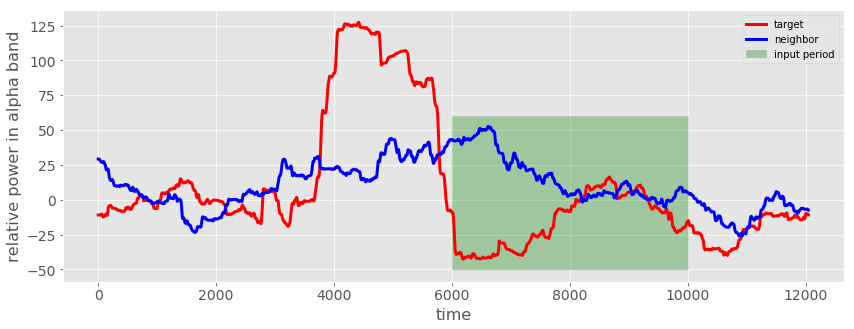

In [457]:
##################
# power analysis #
##################

# calculations
##############

# amplitude squaring
squared_filtered_signals = bpass_filtered_signals**2

# power calculation
window_length = int(2. / step_size)
iterations = squared_filtered_signals.shape[1] - window_length
signal_power = np.zeros((2, iterations))
for i in range(iterations):
    signal_power[:, i] = np.mean(squared_filtered_signals[:, i:i+window_length], axis=1)

# relative power calculation
reference_power = np.mean(signal_power[:,0:window_length], axis=1)
relative_power_1 = (signal_power[0, :] - reference_power[0]) / reference_power[0] * 100.
relative_power_2 = (signal_power[1, :] - reference_power[1]) / reference_power[1] * 100.

# plotting
##########

fig, axes = plt.subplots(figsize=(14,5))
axes.plot(relative_power_1, 'r')
axes.plot(relative_power_2, 'b')
steps = np.arange(0, len(relative_power_1))
axes.fill_between(steps, -50, 60, where=(steps > 6000) * (steps < 10000), color="green", alpha=0.3)
axes.set_xlabel('time')
axes.set_ylabel('relative power in alpha band')
plt.legend(['target', 'neighbor', 'input period'])

Extended model with realistic motor cortex
------------------------------------------------

In [41]:
from core.circuit import CircuitFromCircuit
from models.BGTC import M1, Thalamus

# create extended thalamus model
################################

# thalamus parameters
step_size = 1e-3
max_synaptic_delay = None
resting_potentials = [0., 0.]
connectivity_scaling = 20.
synapse_params = [dict(), {'efficacy': -0.001, 'tau_decay': 1./40}, dict()]

# thalamus object
thalamus = Thalamus(step_size=step_size, max_synaptic_delay=max_synaptic_delay, resting_potentials=resting_potentials,
                    connectivity_scaling=connectivity_scaling, synapse_params=synapse_params)

# m1 parameters
max_synaptic_delay = 1.0

# m1 object
m1 = M1(step_size=step_size, max_synaptic_delay=max_synaptic_delay)

# connectivity
synapse_types = ['AMPA', 'GABAA', 'GABAB', 'excitatory', 'inhibitory']
connection_strengths = [10., 20., 2.]
source_populations = [2, 2, 0]
target_populations = [0, 1, 3]
target_synapses = [0, 0, 3]

# full model
thalamo_cortical_circuit = CircuitFromCircuit([thalamus, m1], connection_strengths=connection_strengths, 
                                              source_populations=source_populations, target_populations=target_populations,
                                              target_synapses=target_synapses, synapse_types=synapse_types,
                                              circuit_labels=['Th', 'M1'])

# perform simulation
####################

# simulation params
simulation_time = 3.
cutoff_time = 2.
simulation_steps = int(simulation_time / step_size)
sensory_inp_mean = 150.
sensory_inp_var = 4.

synaptic_input = np.zeros((simulation_steps, 6, 5))
synaptic_input[:, 0, 0] = sensory_inp_var * np.random.randn(simulation_steps) + sensory_inp_mean
synaptic_input[:, 3, 3] = sensory_inp_var * np.random.randn(simulation_steps) + sensory_inp_mean

# run
thalamo_cortical_circuit.run(synaptic_input, simulation_time)

/home/raid2/rgast/anaconda3/envs/mne_gpc/lib/python3.6/site-packages/PyRates-0.2-py3.6.egg/core/utility/bio_features.py:206: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp((firing_rate - threshold) / steepness))


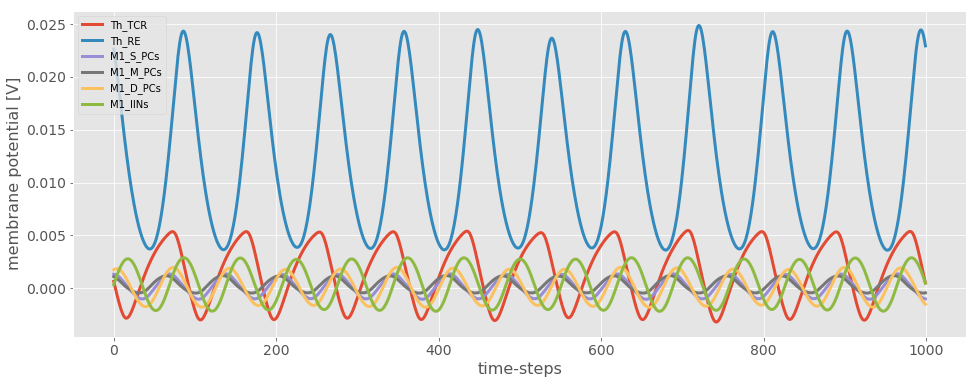

In [42]:
fig, axes = plt.subplots(figsize=(16, 6))
axes = thalamo_cortical_circuit.plot_population_states(create_plot=False, axes=axes, time_window=[cutoff_time, simulation_time])